## Data Science - CA4 - RNN

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
# from google.colab import drive
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Dropout
import seaborn as sns
# drive.mount('/content/drive')

### Dataset Loading

In [6]:
file_path = './BTC-USD.csv'
df = pd.read_csv(file_path, parse_dates=['Date'])
if "Unnamed: 0" in df.columns:
    df = df.drop(columns = ["Unnamed: 0"])
df = df.set_index('Date').sort_index()

In [7]:
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100


In [8]:
df.shape

(3222, 5)

As we can see above, the dataset is successfully loaded. Now I will explain about the dataset itself and what is each feature and how it is calculated. The dataset contains daily Bitcoin prices with columns:
- Date : This is the specific date for which the price and volume data are recorded. For daily data, this represents a 24-hour period.
- Open : This is the first trade price recorded just after midnight (UTC) for that 24-hour period. It is taken directly from the exchange’s order book snapshot at the start of the day.
- High : This is the highest price Bitcoin reached at any point during that trading day. It is obtained by continuous scan through all trades and then the max value is stored.
- Low : This is the lowest traded price reached during that day. It is obtained by continuous scan through all trades and then the min value is stored.
- Close : This is the closing price of Bitcoin at the end of that trading day. This price is often considered very significant as it's the most recent valuation for the day. It is obtained by snapshot at the end of the day.
- Volume : This represents the total quantity of Bitcoin traded during that specific day. So, if on a particular day, the "Volume" is 21,056,800, it means that approximately $21,056,800 worth of Bitcoin was bought and sold on that day across the exchanges from which this data was sourced. It is obtained by sum of the “amount” field from all trades between midnight and 23:59 (during that day).

### Exploratory Data Analysis (EDA)

Below is the statistical summary of the features in the whole dataset:

In [9]:
df.describe()

,Open,High,Low,Close,Volume
count,3222.000000,3222.000000,3222.000000,3222.000000,3.222000e+03
mean,13633.555524,13966.498897,13269.790975,13641.491658,1.657062e+10
std,16016.593310,16417.423832,15559.562019,16014.439000,1.950701e+10
min,176.897003,211.731003,171.509995,178.102997,5.914570e+06
25%,757.838730,772.024277,745.732499,759.970260,1.300485e+08
50%,7664.044434,7867.845215,7499.634766,7679.053711,1.017502e+10
75%,20210.792481,20660.277832,19811.524414,20238.632813,2.746342e+10
max,67549.734375,68789.625000,66382.062500,67566.828125,3.509679e+11


In [10]:
print("Date range: ", df.index.min().date(), ", ", df.index.max().date())

Date range:  2014-09-17 ,  2023-07-13


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3222 entries, 2014-09-17 to 2023-07-13
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    3222 non-null   float64
 1   High    3222 non-null   float64
 2   Low     3222 non-null   float64
 3   Close   3222 non-null   float64
 4   Volume  3222 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 151.0 KB


Below are the plots of each column over time:

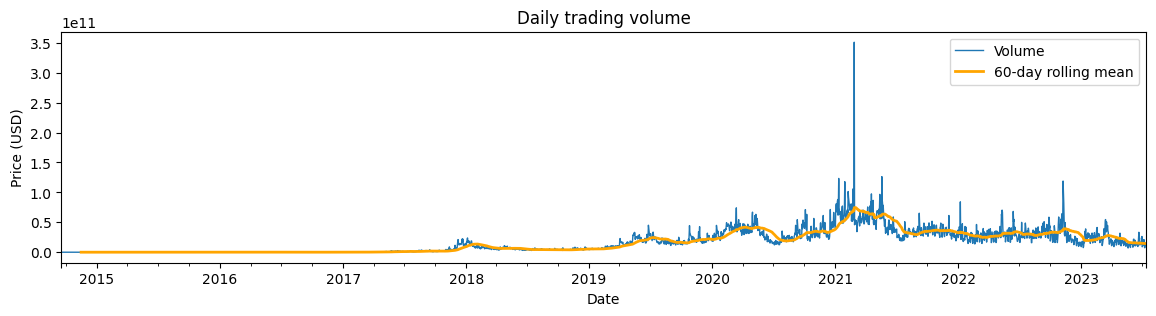

In [12]:
fig, ax = plt.subplots(figsize=(14, 3))
df['Volume'].plot(ax=ax, linewidth=1, grid=True)
ax.set_title('Daily trading volume')
df['Volume'].rolling(60).mean().plot(
    ax=ax, color='orange', linewidth=2, label='60-day rolling mean'
)
ax.set_ylabel('Price (USD)')
ax.legend()
plt.show()


As we can see above, the plot is non-stationary because statistical properties (like mean) don't remain constant over time and there are obvious peaks in 2021 and 2022. I have also drawn the trend line for it and it has strong non-linear upward trend. I have drawn the trend using rolling (also called moving or sliding-window operation) which takes the last k observations (here I used 60 days), apply a function (mean, sum, std, max, etc. here I used mean), then slide the window forward by one step and repeat for the whole series.

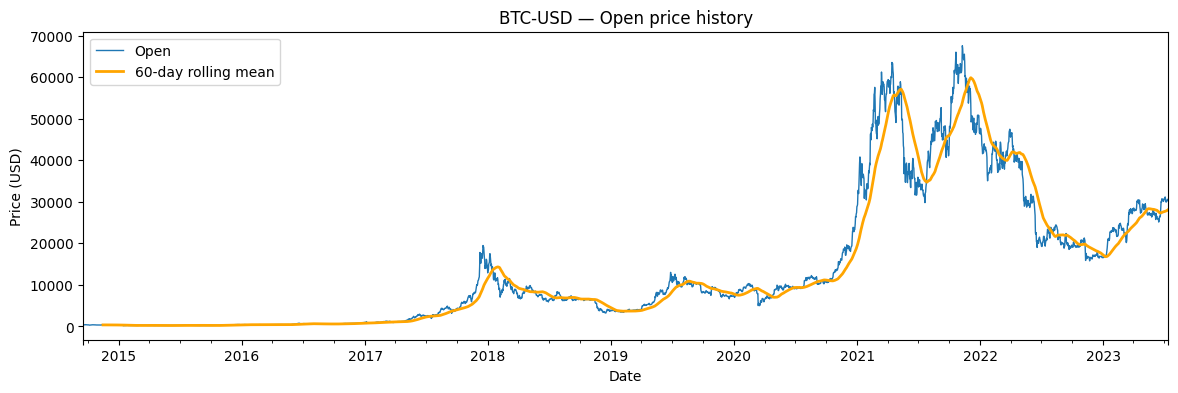

In [13]:
fig, ax = plt.subplots(figsize=(14, 4))
df[['Open']].plot(ax=ax, linewidth=1, grid=True)
ax.set_title('BTC-USD — Open price history')
df['Open'].rolling(60).mean().plot(
    ax=ax, color='orange', linewidth=2, label='60-day rolling mean'
)
ax.set_ylabel('Price (USD)')
ax.legend()
plt.show()


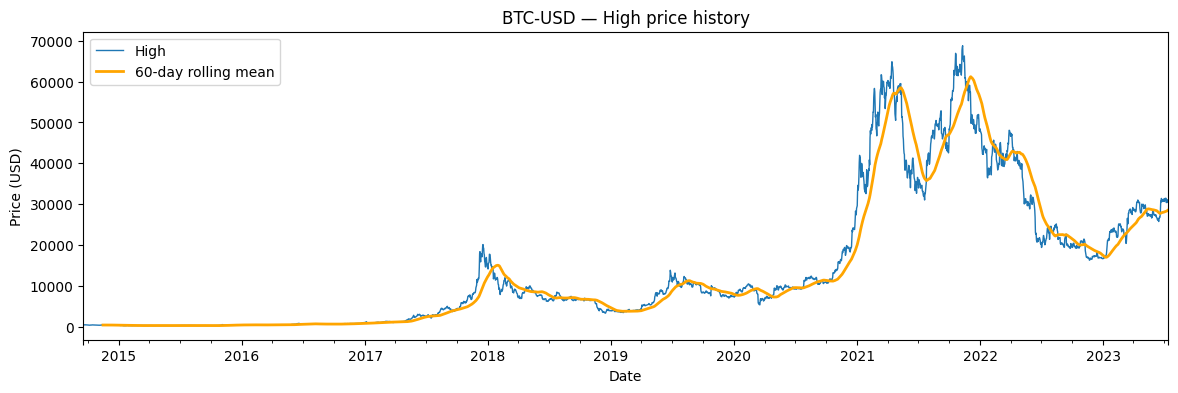

In [14]:
fig, ax = plt.subplots(figsize=(14, 4))
df[['High']].plot(ax=ax, linewidth=1, grid=True)
ax.set_title('BTC-USD — High price history')
df['High'].rolling(60).mean().plot(
    ax=ax, color='orange', linewidth=2, label='60-day rolling mean'
)
ax.set_ylabel('Price (USD)')
ax.legend()
plt.show()


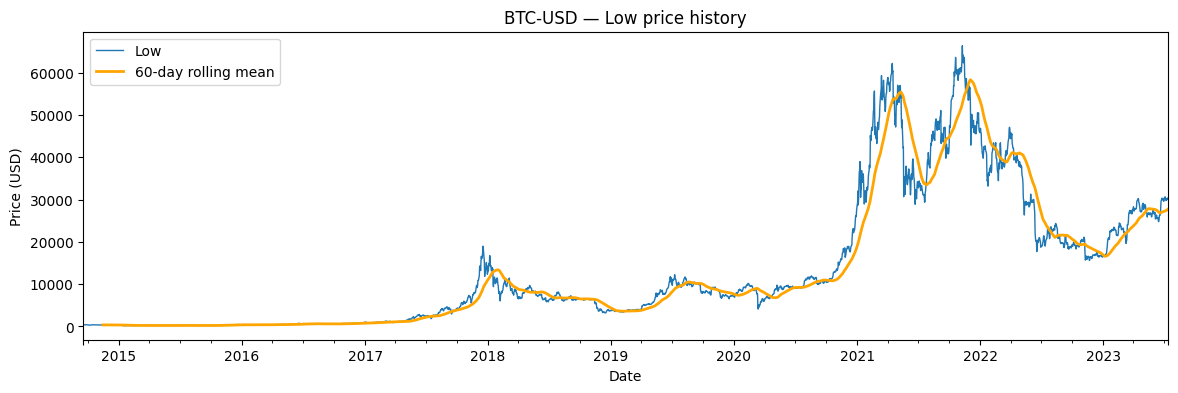

In [15]:
fig, ax = plt.subplots(figsize=(14, 4))
df[['Low']].plot(ax=ax, linewidth=1, grid=True)
ax.set_title('BTC-USD — Low price history')
df['Low'].rolling(60).mean().plot(
    ax=ax, color='orange', linewidth=2, label='60-day rolling mean'
)
ax.set_ylabel('Price (USD)')
ax.legend()
plt.show()


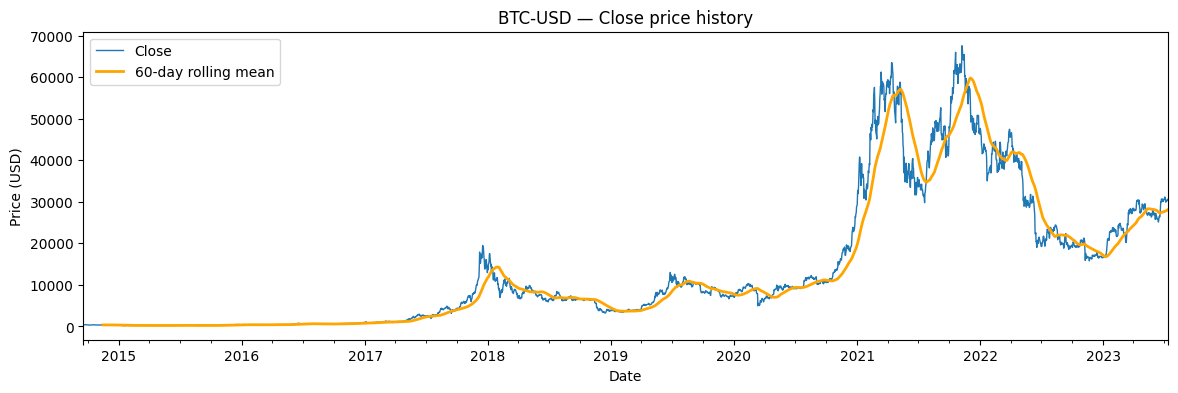

In [16]:
fig, ax = plt.subplots(figsize=(14, 4))
df[['Close']].plot(ax=ax, linewidth=1, grid=True)
ax.set_title('BTC-USD — Close price history')
df['Close'].rolling(60).mean().plot(
    ax=ax, color='orange', linewidth=2, label='60-day rolling mean'
)
ax.set_ylabel('Price (USD)')
ax.legend()
plt.show()

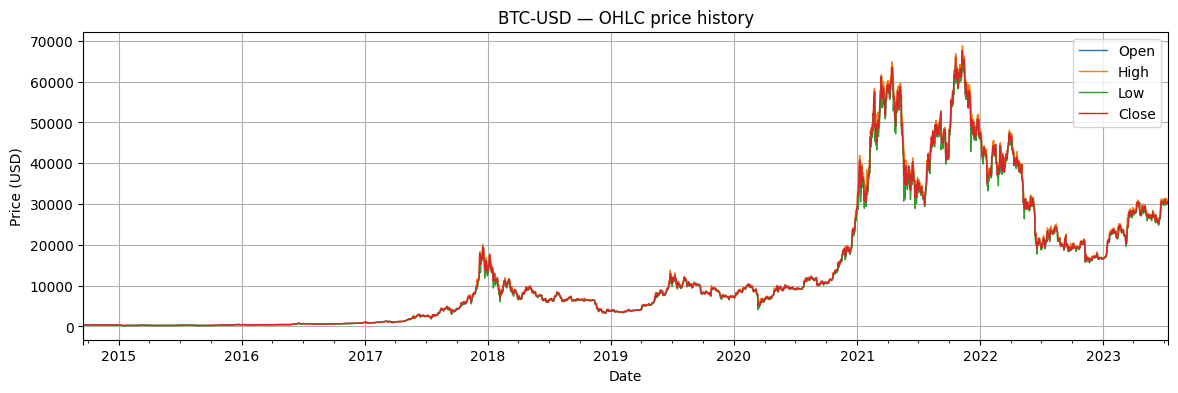

In [17]:
fig, ax = plt.subplots(figsize=(14, 4))
df[['Open', 'High', 'Low', 'Close']].plot(ax=ax, linewidth=1, grid=True)
ax.set_title('BTC-USD — OHLC price history')
ax.set_ylabel('Price (USD)')
plt.show()


As we can see, the OHLC plots are non-stationary too and I have draw the trend lines for each of them too which have a more increasing trend than the volume plot.

Also these 4 features' plots are really close together and maybe they have high correlation. We will examine this below:

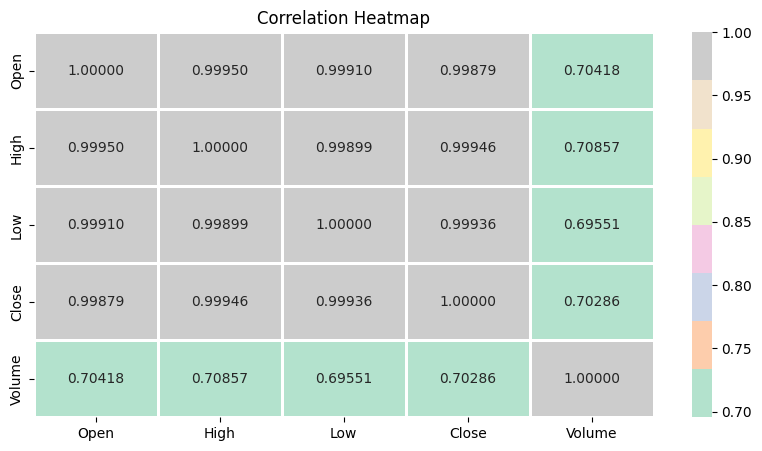

In [18]:
plt.figure(figsize=(10, 5))

sns.heatmap(df.corr(), annot=True, fmt='.5f', cmap='Pastel2', linewidths=2)

plt.title('Correlation Heatmap')
plt.show()

As we can see above, the 4 OHLC features are completely correlated and so we can keep only one of them in the next part (preparing data) to reduce input size and training time without losing signal. We will keep "Close" only.

### Data Processing

In [19]:
print("Missing values before handling (if any):")
print(df.isnull().sum())

Missing values before handling (if any):
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


In [20]:
input_features = ['Open','Close','Volume', 'High','Low']

df['High_NextDay'] = df['High'].shift(-1)
df['Low_NextDay'] = df['Low'].shift(-1)

df['Target'] = (df['High_NextDay'] + df['Low_NextDay']) / 2
df.dropna(subset=['Target'], inplace=True)
df.drop(columns=['High_NextDay', 'Low_NextDay'], inplace=True)

In [21]:
df.head()

,Open,High,Low,Close,Volume,Target
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,434.981994
2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,406.183502
2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,406.589493
2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,402.803497
2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,402.022995


As we can see, there isn't any missing value

In [22]:
target_feature = 'Target'

data_for_processing = df[input_features + [target_feature]].copy()

data_len = len(data_for_processing)
train_split_idx = int(data_len * 0.7)
val_split_idx = int(data_len * 0.8)

train_data = data_for_processing.iloc[:train_split_idx]
val_data = data_for_processing.iloc[train_split_idx:val_split_idx]
test_data = data_for_processing.iloc[val_split_idx:]

print(f"Training set shape: {train_data.shape}")
print(f"Validation set shape: {val_data.shape}")
print(f"Test set shape: {test_data.shape}")

input_feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

input_feature_scaler.fit(train_data[input_features])
target_scaler.fit(train_data[[target_feature]])

train_data_scaled = train_data.copy()
val_data_scaled = val_data.copy()
test_data_scaled = test_data.copy()

train_data_scaled[input_features] = input_feature_scaler.transform(train_data[input_features])
train_data_scaled[target_feature] = target_scaler.transform(train_data[[target_feature]])

val_data_scaled[input_features] = input_feature_scaler.transform(val_data[input_features])
val_data_scaled[target_feature] = target_scaler.transform(val_data[[target_feature]])

test_data_scaled[input_features] = input_feature_scaler.transform(test_data[input_features])
test_data_scaled[target_feature] = target_scaler.transform(test_data[[target_feature]])

Training set shape: (2254, 6)
Validation set shape: (322, 6)
Test set shape: (645, 6)


In [23]:
train_data.head()

,Open,Close,Volume,High,Low,Target
Date,,,,,,
2014-09-17,465.864014,457.334015,21056800,468.174011,452.421997,434.981994
2014-09-18,456.859985,424.440002,34483200,456.859985,413.104004,406.183502
2014-09-19,424.102997,394.795990,37919700,427.834991,384.532013,406.589493
2014-09-20,394.673004,408.903992,36863600,423.295990,389.882996,402.803497
2014-09-21,408.084991,398.821014,26580100,412.425995,393.181000,402.022995


Below is the target feature plot along with 60 day rolling mean trend:

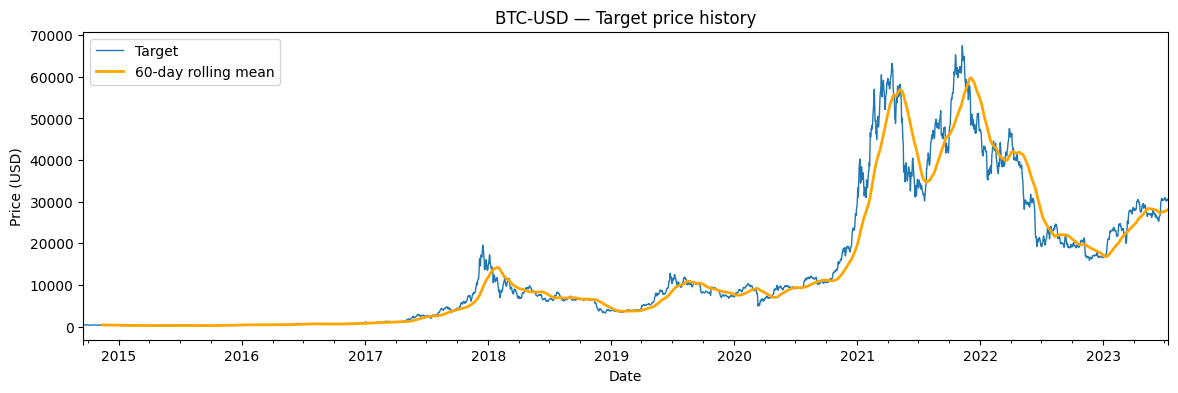

In [24]:
fig, ax = plt.subplots(figsize=(14, 4))
df[['Target']].plot(ax=ax, linewidth=1, grid=True)
ax.set_title('BTC-USD — Target price history')
df['Target'].rolling(60).mean().plot(
    ax=ax, color='orange', linewidth=2, label='60-day rolling mean'
)
ax.set_ylabel('Price (USD)')
ax.legend()
plt.show()


In [25]:
def create_sequences_from_df(df_scaled, input_cols, target_col, lookback_period):
    X_sequences = []
    y_sequences = []
    input_data_np = df_scaled[input_cols].values
    target_data_np = df_scaled[target_col].values

    for i in range(len(input_data_np) - lookback_period):
        X_sequences.append(input_data_np[i:(i + lookback_period)])
        y_sequences.append(target_data_np[i + lookback_period])
    return np.array(X_sequences), np.array(y_sequences)

lookback_period = 30

X_train, y_train = create_sequences_from_df(train_data_scaled, input_features, target_feature, lookback_period)
X_val, y_val = create_sequences_from_df(val_data_scaled, input_features, target_feature, lookback_period)
X_test, y_test = create_sequences_from_df(test_data_scaled, input_features, target_feature, lookback_period)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_val: {X_val.shape}")
print(f"Shape of y_val: {y_val.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (2224, 30, 5)
Shape of y_train: (2224,)
Shape of X_val: (292, 30, 5)
Shape of y_val: (292,)
Shape of X_test: (615, 30, 5)
Shape of y_test: (615,)


#### Why using both a validation and test set is better than relying on just a test set?

We need a validation set for tuning our model during the training phase cause we don't have access to test data and we need a dataset like validation set to tune our model. If we only used a training set and a test set, we would likely use the test set to tune wer hyperparameters or make decisions about our model architecture. If we do this, our model might become overly optimized for that specific test set. Consequently, the performance metrics we get from that test set would be overly optimistic and not a true reflection of how the model would perform on other, genuinely new data. The test set, in this scenario, loses its power as an unbiased evaluator.

By using a validation set for all the intermediate decision-making and reserving the test set for a final, one-off evaluation, we maintain the integrity of the testing process and get a much more reliable assessment of our model's true generalization capabilities.

### Model Architecture

In [ ]:
dropout_rate = 0.2
model_RNN = Sequential([
    SimpleRNN(units=32, input_shape=(lookback_period, len(input_features)), activation="tanh", return_sequences=False, name="RNN_1"),
    Dropout(dropout_rate, name="Dropout_1"),
    keras.layers.Dense(16, activation='relu', name="FC1"),
    keras.layers.Dropout(dropout_rate, name="Dropout_2"),
    Dense(1, name="Output_Layer")
])
model_RNN.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

model_RNN.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ RNN_1 (SimpleRNN)               │ (None, 32)             │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ FC1 (Dense)                     │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,761 (6.88 KB)

 Trainable params: 1,761 (6.88 KB)

 Non-trainable params: 0 (0.00 B)

### Model Training

In [27]:
history = model_RNN.fit(
        X_train, y_train,
        epochs=100,
        batch_size=64,
        validation_data=(X_val, y_val),
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)],
        verbose=1
)

Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0652 - mean_absolute_error: 0.1516 - val_loss: 0.5583 - val_mean_absolute_error: 0.6793
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0143 - mean_absolute_error: 0.0774 - val_loss: 0.5152 - val_mean_absolute_error: 0.6482
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0103 - mean_absolute_error: 0.0644 - val_loss: 0.5160 - val_mean_absolute_error: 0.6487
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0095 - mean_absolute_error: 0.0597 - val_loss: 0.5065 - val_mean_absolute_error: 0.6389
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0085 - mean_absolute_error: 0.0581 - val_loss: 0.4774 - val_mean_absolute_error: 0.6167
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0074 - mean_absolute_error: 0.0539 - val_loss: 0.4726 - val_mean_absolute_error: 0.6120
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0066 - mean_absolute_error: 0.0527 - val

### Evaluation and Visualization

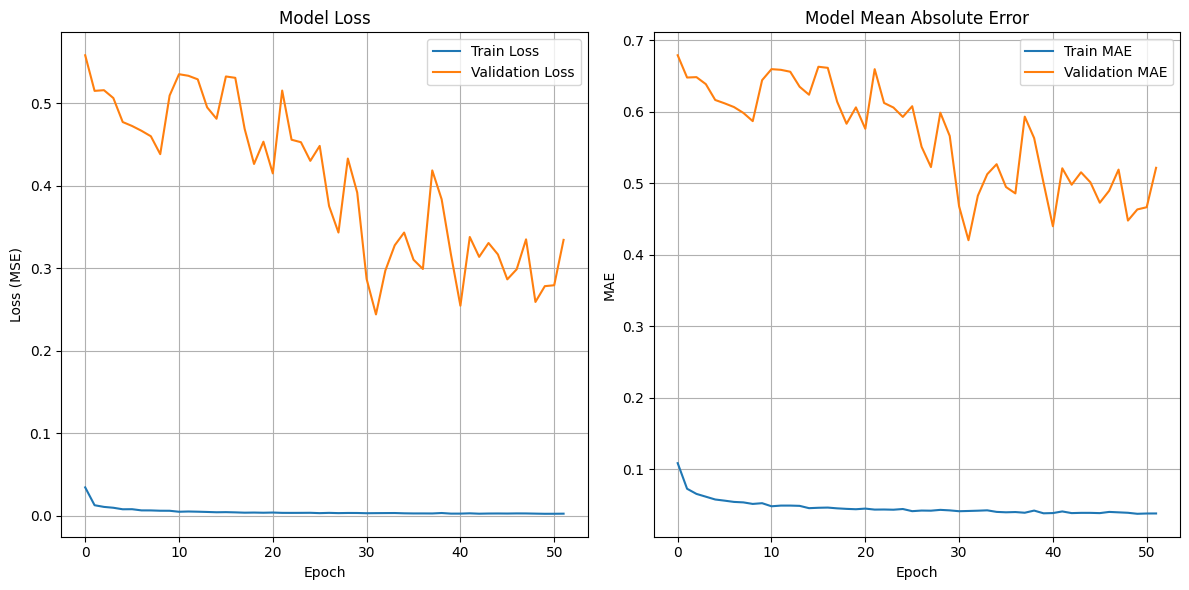

In [28]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['mean_absolute_error'], label='Train MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.title('Model Mean Absolute Error')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()

In [29]:
predictions_train_scaled = model_RNN.predict(X_train)
predictions_test_scaled = model_RNN.predict(X_test)

if y_train.ndim == 1:
    y_train_reshaped = y_train.reshape(-1, 1)
else:
    y_train_reshaped = y_train

if y_test.ndim == 1:
    y_test_reshaped = y_test.reshape(-1, 1)
else:
    y_test_reshaped = y_test

actual_train_unscaled = target_scaler.inverse_transform(y_train_reshaped)
predictions_train_unscaled = target_scaler.inverse_transform(predictions_train_scaled)

actual_test_unscaled = target_scaler.inverse_transform(y_test_reshaped)
predictions_test_unscaled = target_scaler.inverse_transform(predictions_test_scaled)

print(f"Shape of unscaled actual_test_unscaled: {actual_test_unscaled.shape}")
print(f"Shape of unscaled predictions_test_unscaled: {predictions_test_unscaled.shape}")

70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Shape of unscaled actual_test_unscaled: (615, 1)
Shape of unscaled predictions_test_unscaled: (615, 1)


In [30]:
# MSE
mse_test = mean_squared_error(actual_test_unscaled, predictions_test_unscaled)
print(f"MSE: {mse_test:.4f}")

# RMSE
rmse_test = np.sqrt(mse_test)
print(f"\nRMSE: {rmse_test:.4f}")

# MAE
mae_test = mean_absolute_error(actual_test_unscaled, predictions_test_unscaled)
print(f"\nMAE: {mae_test:.4f}")

# MAPE
mape_test = np.mean(np.abs((actual_test_unscaled - predictions_test_unscaled) / actual_test_unscaled)) * 100
print(f"\nMAPE: {mape_test:.2f}%")


# Cumulative Error (CE)
cumulative_error_test = np.sum(actual_test_unscaled - predictions_test_unscaled)
print(f"\nCE: {cumulative_error_test:.4f}")

# R2 Score
r2 = r2_score(y_test, predictions_test_scaled)
print("\nR² score:", r2)

MSE: 27008728.8093

RMSE: 5196.9923

MAE: 3222.7250

MAPE: 8.51%

CE: 1898793.1211

R² score: 0.7934008189395714


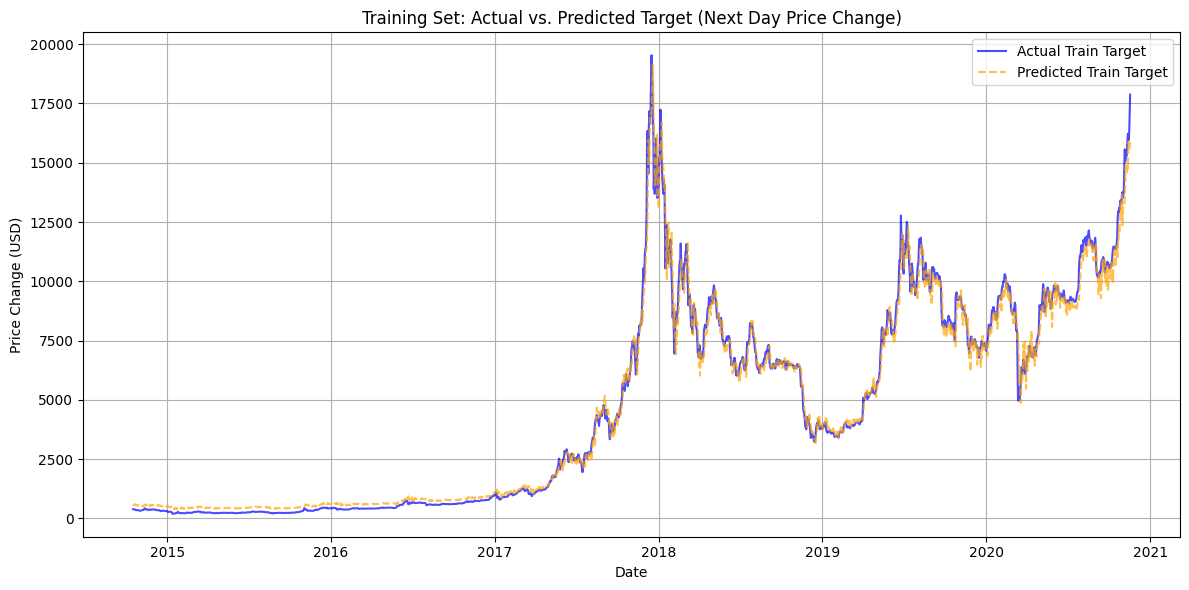

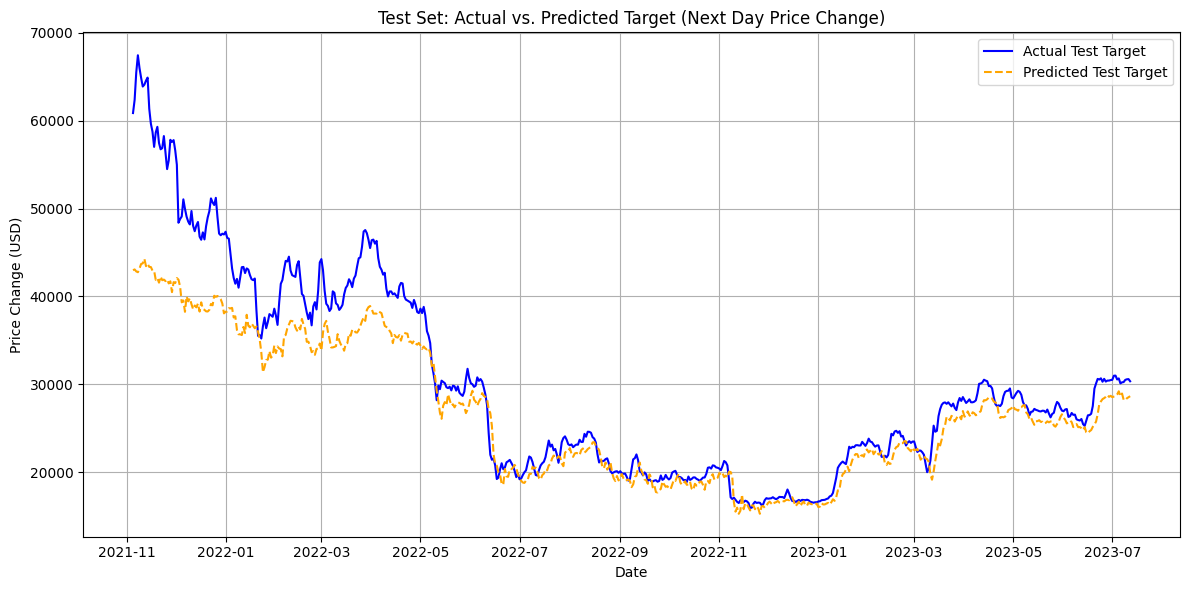

In [31]:
train_dates = train_data_scaled.index[lookback_period : lookback_period + len(actual_train_unscaled)]
test_dates = test_data_scaled.index[lookback_period : lookback_period + len(actual_test_unscaled)]

df_train_results = pd.DataFrame({'Date': train_dates, 'Actual': actual_train_unscaled.flatten(), 'Predicted': predictions_train_unscaled.flatten()})
df_train_results.set_index('Date', inplace=True)

df_test_results = pd.DataFrame({'Date': test_dates, 'Actual': actual_test_unscaled.flatten(), 'Predicted': predictions_test_unscaled.flatten()})
df_test_results.set_index('Date', inplace=True)

# Plot for Training Set
plt.figure(figsize=(12, 6))
plt.plot(df_train_results.index, df_train_results['Actual'], label='Actual Train Target', color='blue', alpha=0.7)
plt.plot(df_train_results.index, df_train_results['Predicted'], label='Predicted Train Target', color='orange', linestyle='--', alpha=0.7)
plt.title('Training Set: Actual vs. Predicted Target (Next Day Price Change)')
plt.xlabel('Date')
plt.ylabel('Price Change (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot for Test Set
plt.figure(figsize=(12, 6))
plt.plot(df_test_results.index, df_test_results['Actual'], label='Actual Test Target', color='blue')
plt.plot(df_test_results.index, df_test_results['Predicted'], label='Predicted Test Target', color='orange', linestyle='--')
plt.title('Test Set: Actual vs. Predicted Target (Next Day Price Change)')
plt.xlabel('Date')
plt.ylabel('Price Change (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

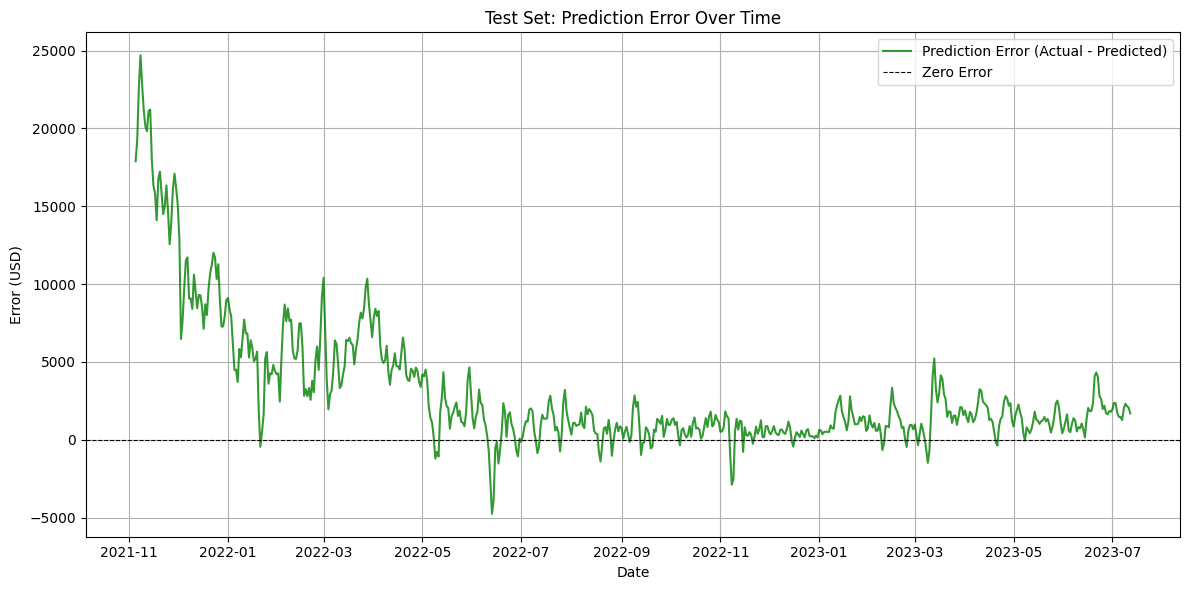

In [32]:
df_test_results['Error'] = df_test_results['Actual'] - df_test_results['Predicted']

plt.figure(figsize=(12, 6))
plt.plot(df_test_results.index, df_test_results['Error'], label='Prediction Error (Actual - Predicted)', color='green', alpha=0.8)
plt.axhline(0, color='black', linestyle='--', linewidth=0.8, label='Zero Error')
plt.title('Test Set: Prediction Error Over Time')
plt.xlabel('Date')
plt.ylabel('Error (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## LSTM (Bonus)

In [33]:
def create_sequences_from_df(df_scaled, input_cols, target_col, lookback_period):
    X_sequences = []
    y_sequences = []
    input_data_np = df_scaled[input_cols].values
    target_data_np = df_scaled[target_col].values

    for i in range(len(input_data_np) - lookback_period):
        X_sequences.append(input_data_np[i:(i + lookback_period)])
        y_sequences.append(target_data_np[i + lookback_period])
    return np.array(X_sequences), np.array(y_sequences)

lookback_period = 60

X_train, y_train = create_sequences_from_df(train_data_scaled, input_features, target_feature, lookback_period)
X_val, y_val = create_sequences_from_df(val_data_scaled, input_features, target_feature, lookback_period)
X_test, y_test = create_sequences_from_df(test_data_scaled, input_features, target_feature, lookback_period)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_val: {X_val.shape}")
print(f"Shape of y_val: {y_val.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (2194, 60, 5)
Shape of y_train: (2194,)
Shape of X_val: (262, 60, 5)
Shape of y_val: (262,)
Shape of X_test: (585, 60, 5)
Shape of y_test: (585,)


In [48]:
# model_RNN = keras.Sequential([
#     keras.layers.Input(shape=(lookback_period, len(input_features))),
#     keras.layers.LSTM(32, return_sequences=True, name="LSTM1"),
#     keras.layers.Dropout(0.4),
#     keras.layers.LSTM(16,return_sequences=False, name="LSTM2"),
#     keras.layers.Dense(16, activation='relu', name="FC1"),
#     keras.layers.Dropout(0.4),
#     keras.layers.Dense(1, name="output")
# ])
# model_RNN.compile(optimizer=keras.optimizers.Adam(1e-3),
#               loss='mean_squared_error', metrics=['mean_absolute_error'])

# model_RNN.summary()
model_RNN = keras.Sequential([
    keras.layers.Input(shape=(lookback_period, len(input_features))),
    keras.layers.LSTM(16, return_sequences=False, name="LSTM1"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, name="output")
])
model_RNN.compile(optimizer=keras.optimizers.Adam(1e-3),
              loss='mean_squared_error', metrics=['mean_absolute_error'])

model_RNN.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ LSTM1 (LSTM)                    │ (None, 16)             │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,425 (5.57 KB)

 Trainable params: 1,425 (5.57 KB)

 Non-trainable params: 0 (0.00 B)

In [49]:
history = model_RNN.fit(
        X_train, y_train,
        epochs=100,
        batch_size=64,
        validation_data=(X_val, y_val),
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)],
        verbose=1
)

Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 0.0217 - mean_absolute_error: 0.0932 - val_loss: 2.9316 - val_mean_absolute_error: 1.6240
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0090 - mean_absolute_error: 0.0549 - val_loss: 2.2918 - val_mean_absolute_error: 1.4222
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0055 - mean_absolute_error: 0.0452 - val_loss: 1.9991 - val_mean_absolute_error: 1.3213
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0052 - mean_absolute_error: 0.0442 - val_loss: 1.7137 - val_mean_absolute_error: 1.2189
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0037 - mean_absolute_error: 0.0367 - val_loss: 1.5618 - val_mean_absolute_error: 1.1562
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0032 - mean_absolute_error: 0.0357 - val_loss: 1.3843 - val_mean_absolute_error: 1.0870
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0028 - mean_absolute_error: 0.0329 - v

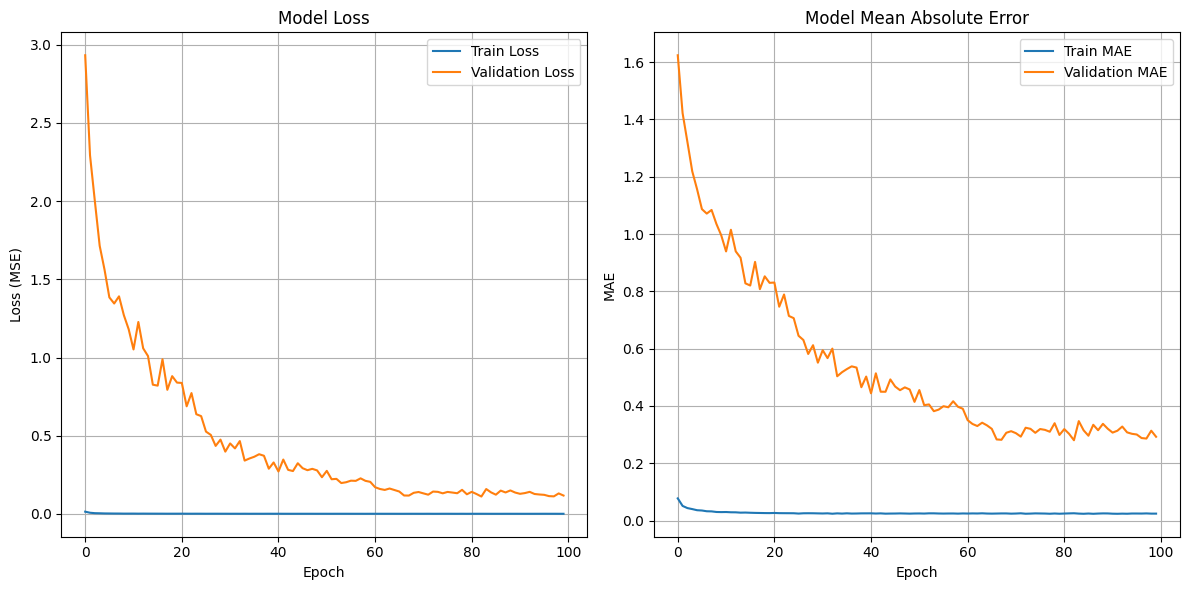

In [50]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['mean_absolute_error'], label='Train MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.title('Model Mean Absolute Error')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()

In [51]:
predictions_train_scaled = model_RNN.predict(X_train)
predictions_test_scaled = model_RNN.predict(X_test)

if y_train.ndim == 1:
    y_train_reshaped = y_train.reshape(-1, 1)
else:
    y_train_reshaped = y_train

if y_test.ndim == 1:
    y_test_reshaped = y_test.reshape(-1, 1)
else:
    y_test_reshaped = y_test

actual_train_unscaled = target_scaler.inverse_transform(y_train_reshaped)
predictions_train_unscaled = target_scaler.inverse_transform(predictions_train_scaled)

actual_test_unscaled = target_scaler.inverse_transform(y_test_reshaped)
predictions_test_unscaled = target_scaler.inverse_transform(predictions_test_scaled)

print(f"Shape of unscaled actual_test_unscaled: {actual_test_unscaled.shape}")
print(f"Shape of unscaled predictions_test_unscaled: {predictions_test_unscaled.shape}")

69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Shape of unscaled actual_test_unscaled: (585, 1)
Shape of unscaled predictions_test_unscaled: (585, 1)


In [52]:
# MSE
mse_test = mean_squared_error(actual_test_unscaled, predictions_test_unscaled)
print(f"MSE: {mse_test:.4f}")

# RMSE
rmse_test = np.sqrt(mse_test)
print(f"\nRMSE: {rmse_test:.4f}")

# MAE
mae_test = mean_absolute_error(actual_test_unscaled, predictions_test_unscaled)
print(f"\nMAE: {mae_test:.4f}")

# MAPE
mape_test = np.mean(np.abs((actual_test_unscaled - predictions_test_unscaled) / actual_test_unscaled)) * 100
print(f"\nMAPE: {mape_test:.2f}%")


# Cumulative Error (CE)
cumulative_error_test = np.sum(actual_test_unscaled - predictions_test_unscaled)
print(f"\nCE: {cumulative_error_test:.4f}")

# R2 Score
r2 = r2_score(y_test, predictions_test_scaled)
print("\nR² score:", r2)

MSE: 5141227.7629

RMSE: 2267.4276

MAE: 1555.2901

MAPE: 4.72%

CE: 791103.6866

R² score: 0.9426945277775567


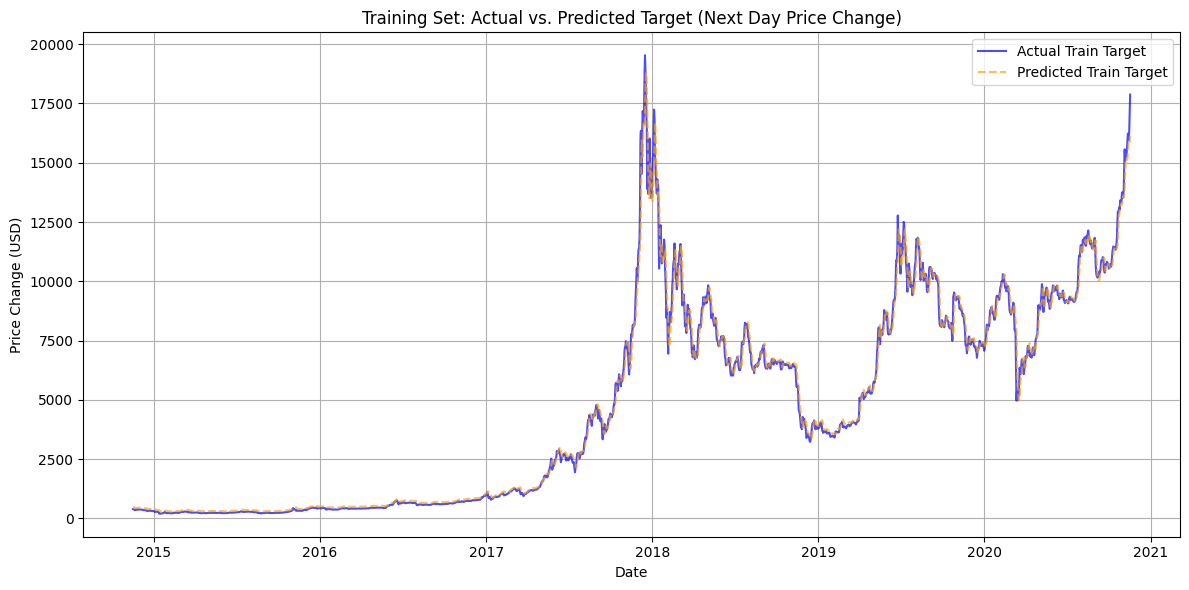

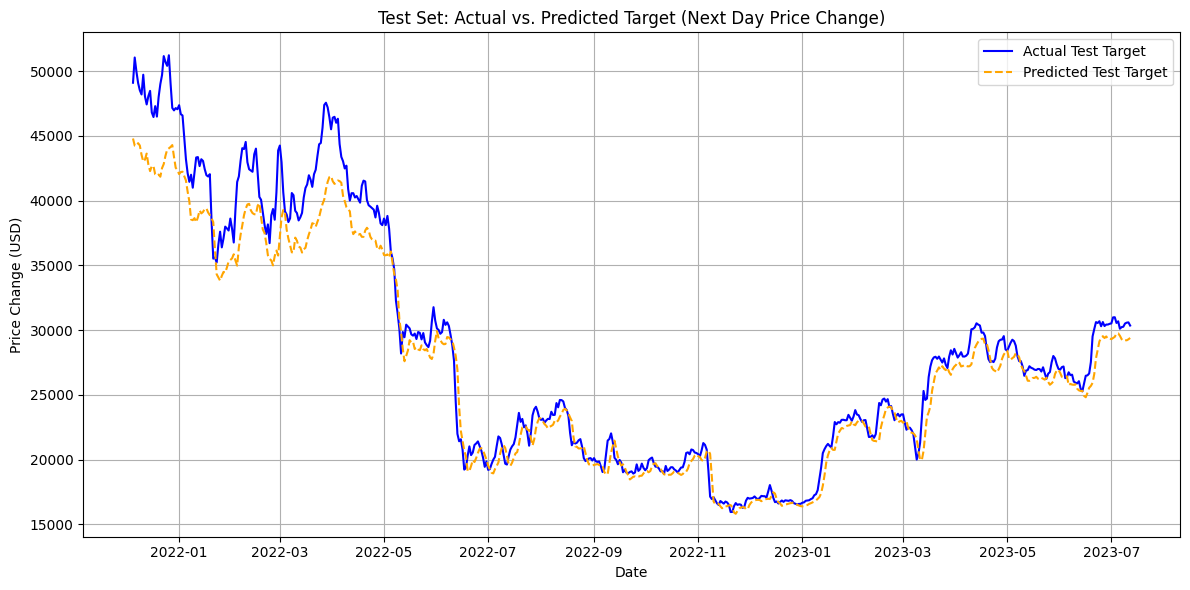

In [53]:
train_dates = train_data_scaled.index[lookback_period : lookback_period + len(actual_train_unscaled)]
test_dates = test_data_scaled.index[lookback_period : lookback_period + len(actual_test_unscaled)]

df_train_results = pd.DataFrame({'Date': train_dates, 'Actual': actual_train_unscaled.flatten(), 'Predicted': predictions_train_unscaled.flatten()})
df_train_results.set_index('Date', inplace=True)

df_test_results = pd.DataFrame({'Date': test_dates, 'Actual': actual_test_unscaled.flatten(), 'Predicted': predictions_test_unscaled.flatten()})
df_test_results.set_index('Date', inplace=True)

plt.figure(figsize=(12, 6))
plt.plot(df_train_results.index, df_train_results['Actual'], label='Actual Train Target', color='blue', alpha=0.7)
plt.plot(df_train_results.index, df_train_results['Predicted'], label='Predicted Train Target', color='orange', linestyle='--', alpha=0.7)
plt.title('Training Set: Actual vs. Predicted Target (Next Day Price Change)')
plt.xlabel('Date')
plt.ylabel('Price Change (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(df_test_results.index, df_test_results['Actual'], label='Actual Test Target', color='blue')
plt.plot(df_test_results.index, df_test_results['Predicted'], label='Predicted Test Target', color='orange', linestyle='--')
plt.title('Test Set: Actual vs. Predicted Target (Next Day Price Change)')
plt.xlabel('Date')
plt.ylabel('Price Change (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

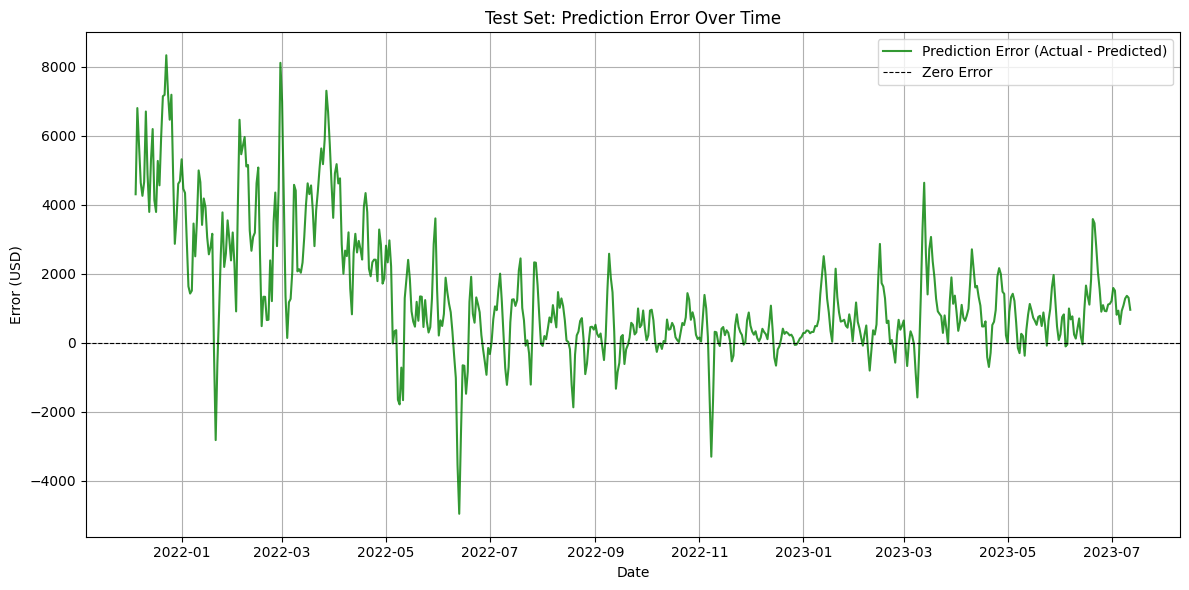

In [54]:
df_test_results['Error'] = df_test_results['Actual'] - df_test_results['Predicted']

plt.figure(figsize=(12, 6))
plt.plot(df_test_results.index, df_test_results['Error'], label='Prediction Error (Actual - Predicted)', color='green', alpha=0.8)
plt.axhline(0, color='black', linestyle='--', linewidth=0.8, label='Zero Error')
plt.title('Test Set: Prediction Error Over Time')
plt.xlabel('Date')
plt.ylabel('Error (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


As we can see, the MAE for LSTM is nearly half of SimpleRNN and also R2score is way better than SimpleRNN. This shows that LSTM is much better than SimpleRNN for this dataset and problem. Here we have longer-term patterns to be learned that is financial time series. SimpleRNNs have a straightforward recurrent structure where the output at a time step t is a function of the input at t and the hidden state from the previous time step t-1. This hidden state serves as the network's "memory". However, as information cycles through these recurrent connections repeatedly, it undergoes multiple transformations (e.g., multiplication by weight matrices, application of activation functions).
For longer sequences, this process makes it very difficult for SimpleRNNs to retain information or dependencies from earlier time steps. The "memory" effectively becomes too diluted or overwritten by more recent inputs. This is often referred to as the "short-term memory problem". LSTMs were introduced specifically to address these shortcomings. They achieve this through a more complex internal unit called a "memory cell" which includes several "gates" that regulate the flow of information.

### Bonus Question: Explain mathematically the vanishing gradient problem in Recurrent Neural Networks (RNNs). Then, analyze how changing the lookback window size impacts the severity of this phenomenon.

#### Asnwer:

* During **back-propagation-through-time (BPTT)** the network sends an
  “error signal” from the last time-step (*T*) back to earlier
  steps (… *T-3*, *T-2*, *T-1*).
*  At **every step** that signal is **multiplied** by:
  1. The recurrent weight matrix   **W<sub>hh</sub>**
  2. The slope of the activation function (e.g. *tanhʹ* ≤ 1)

If each multiplication is ≤ 0.5, after *k* steps the strength is  
  *(0.5)<sup>k</sup>*  →  quickly approaches **zero**  
Result: the network *forgets* how earlier inputs influenced the loss.

For one element of the gradient we get  

$
\bigl|\nabla_{t}\mathcal{L}\bigr|
\;\approx\;
\underbrace{\bigl|W_{hh}\bigr|\;\cdot\;\bigl|\phi'(\cdot)\bigr|}_{\text{“shrink factor”, call it }\gamma}
           ^{\text{applied }(T-t)\text{ times}}
$

* **γ** is the shrink factor.  
* The distance from step *t* to the end is **(T − t)**.  

Hence  

$
\bigl|\nabla_{t}\mathcal{L}\bigr|\;\le\;\gamma^{\,T-t}
$

If **γ < 1** the bound falls *exponentially* as the distance grows.


Now if we have Longer windows → more multiplications → more chance the gradient fades away. Choosing the *smallest* window that still captures the patterns we care about, or switch to architectures (LSTM, GRU, Transformers) that have built-in mechanisms to keep the signal alive is useful for dealing with vanishing gradient problem.

